# Neural Network Classification

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [4]:
# Make dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


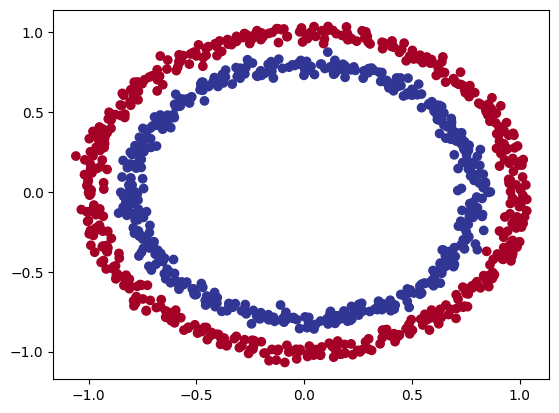

In [5]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1. Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2. Turn data into tensors and create train and test splits

In [8]:
import torch
torch.__version__

'2.1.0+cu118'

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model
Steps:
1. Setup device agnostic code so our code will run on an acceleerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [13]:
# Import PyTorch
import torch
from torch import nn

# Make device agnostic code
device = "cude" if torch.cuda.is_available() else "cpu"
device

'cpu'

Create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our mode class and send it to the target `device`

In [14]:
# 1. Construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear layers capable of handling the shapes of the data
    # self.layer_1 = nn.Linear(in_features=2, out_features=8)
    # self.layer_2 = nn.Linear(in_features=8, out_features=1)

    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=8),
        nn.Linear(in_features=8, out_features=1)
    )

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    # return self.layer_2(self.layer_1(x))
    return self.two_linear_layers(x) # x -> layer_1 -> layer_2 -> output

In [15]:
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
# Replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2114,  0.0627],
                      [ 0.6813,  0.4243],
                      [ 0.0249,  0.4457],
                      [-0.6760, -0.3784],
                      [-0.1944,  0.4541],
                      [-0.5938, -0.3602],
                      [ 0.6994, -0.4913],
                      [-0.1749,  0.6028]])),
             ('0.bias',
              tensor([-0.6914, -0.6053,  0.6251, -0.0667, -0.4743, -0.6264,  0.6028,  0.0649])),
             ('1.weight',
              tensor([[ 0.2922, -0.2384, -0.2756,  0.2437, -0.0261, -0.3433,  0.0474,  0.2253]])),
             ('1.bias', tensor([0.0799]))])

In [19]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1. Setup loss function and optimizer
* For binary classification, the loss is Binary Cross Entropy `torch.nn.BECWithLogitsLoss()`
* For optimizers, two of the most common and useful are SGD and Adam

In [20]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # Included with sigmoid activation (nn.Sigmoid() -> nn.BCELoss())

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [21]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model
Build training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1. Going from raw logits -> prediction probabilities -> prediction labels

The model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert model's prediction probabilities to **prediction labels** by either rounding them of taking the `argmax()`.

In [22]:
# View the first 5 outputs of the forward pass of the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[0.1264],
        [0.0306],
        [0.2631],
        [0.0882],
        [0.0812]])

In [23]:
# Use the sigmoid activation function for our model logits to turn them into predictions probs
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5316],
        [0.5076],
        [0.5654],
        [0.5220],
        [0.5203]])

In [24]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### 3.2. Building a training and testing loop

In [25]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print
  if epoch % 5 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69754, Acc: 53.12% | Test loss: 0.69284, Test acc: 51.50%
Epoch: 5 | Loss: 0.69618, Acc: 51.62% | Test loss: 0.69233, Test acc: 50.50%
Epoch: 10 | Loss: 0.69535, Acc: 51.38% | Test loss: 0.69219, Test acc: 50.50%
Epoch: 15 | Loss: 0.69480, Acc: 51.38% | Test loss: 0.69220, Test acc: 50.50%
Epoch: 20 | Loss: 0.69439, Acc: 51.00% | Test loss: 0.69229, Test acc: 50.00%
Epoch: 25 | Loss: 0.69409, Acc: 50.62% | Test loss: 0.69242, Test acc: 49.50%
Epoch: 30 | Loss: 0.69385, Acc: 50.12% | Test loss: 0.69256, Test acc: 49.50%
Epoch: 35 | Loss: 0.69367, Acc: 50.62% | Test loss: 0.69272, Test acc: 51.00%
Epoch: 40 | Loss: 0.69352, Acc: 50.75% | Test loss: 0.69287, Test acc: 50.50%
Epoch: 45 | Loss: 0.69341, Acc: 50.75% | Test loss: 0.69302, Test acc: 52.00%
Epoch: 50 | Loss: 0.69332, Acc: 50.12% | Test loss: 0.69317, Test acc: 51.50%
Epoch: 55 | Loss: 0.69325, Acc: 49.25% | Test loss: 0.69331, Test acc: 53.50%
Epoch: 60 | Loss: 0.69319, Acc: 49.62% | Test loss: 0.69344, Test 

## 4. Make predictions and evaluate the model

From the metrics it looks like the model isn't learning anything.

In [26]:
import requests
from pathlib import Path

# Download helper functions from github repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/almosenja/PyTorch/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Download helper_functions.py


In [27]:
from helper_functions import plot_predictions, plot_decision_boundary

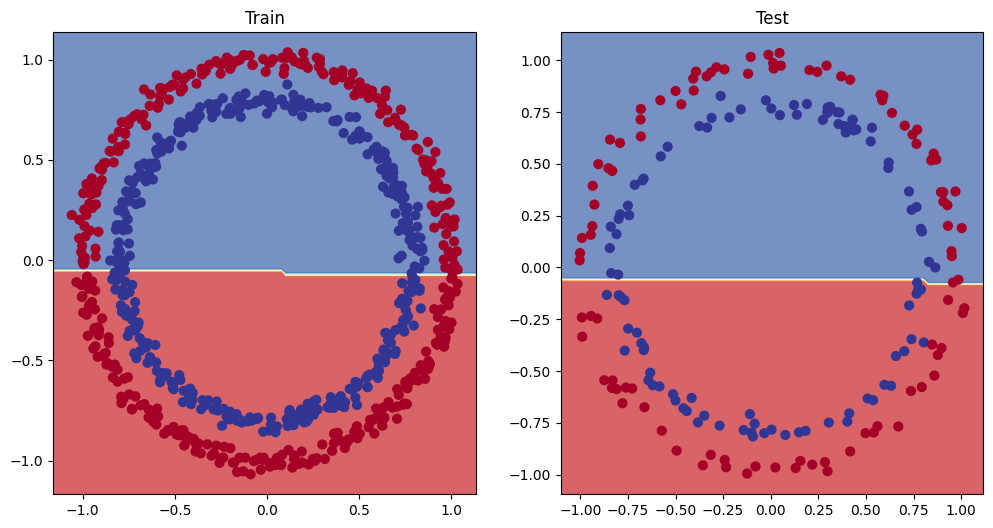

In [28]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [29]:
# Try improve by adding more hidden units, number of layers, and epochs
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=16),
        nn.Linear(in_features=16, out_features=16),
        nn.Linear(in_features=16, out_features=1)
    )

  def forward(self, x):
    return self.layers(x)

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [30]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [31]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print
  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69618, Acc: 50.00% | Test loss: 0.69344, Test acc: 50.00%
Epoch: 50 | Loss: 0.69312, Acc: 51.62% | Test loss: 0.69331, Test acc: 47.00%
Epoch: 100 | Loss: 0.69300, Acc: 51.25% | Test loss: 0.69410, Test acc: 46.00%
Epoch: 150 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69444, Test acc: 45.50%
Epoch: 200 | Loss: 0.69298, Acc: 51.25% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 250 | Loss: 0.69298, Acc: 51.25% | Test loss: 0.69464, Test acc: 45.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69466, Test acc: 46.00%
Epoch: 350 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 450 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 550 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.

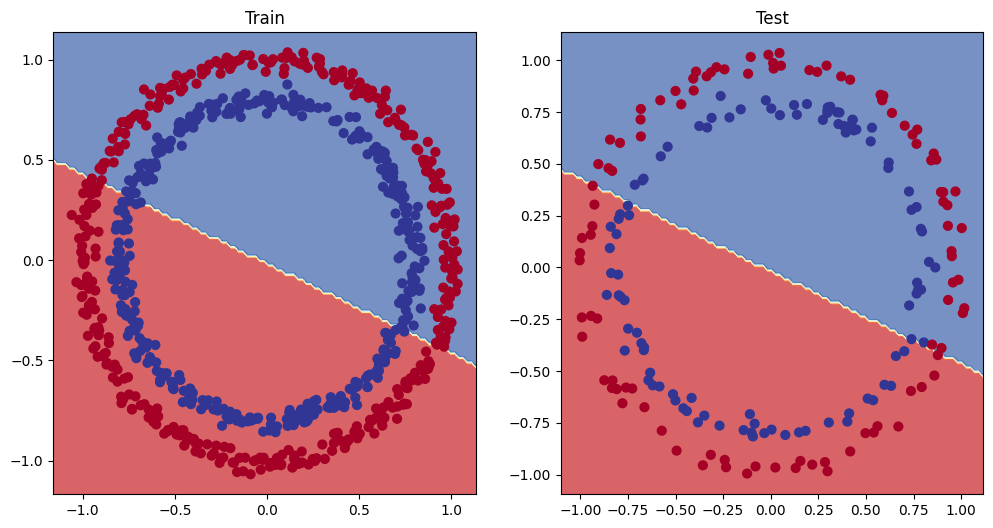

In [32]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The missing piece: non-linearity

### 6.1. Recreating non-linear data (red and blue circles)

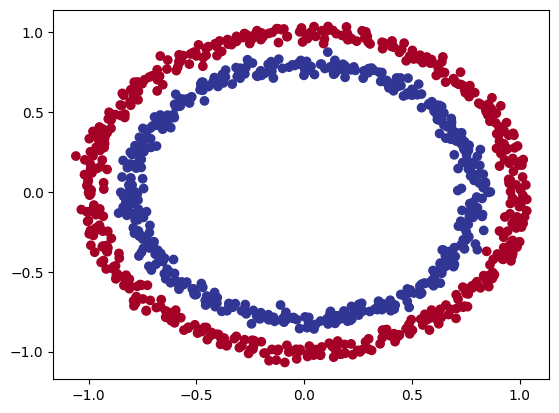

In [33]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [34]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.2. Building a model with non-linearity

In [39]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=1)
    )

  def forward(self, x):
    return self.layers(x)

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [40]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

### 6.3. Training a model with non-linearity

In [41]:
# Random seeds
torch.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_2.train()

  # 1. Forward pass
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6966, Acc: 46.50% | Test loss: 0.6950, Test Acc: 48.50%
Epoch: 10 | Loss: 0.6947, Acc: 47.50% | Test loss: 0.6937, Test Acc: 48.50%
Epoch: 20 | Loss: 0.6935, Acc: 49.25% | Test loss: 0.6929, Test Acc: 48.00%
Epoch: 30 | Loss: 0.6927, Acc: 49.50% | Test loss: 0.6924, Test Acc: 48.00%
Epoch: 40 | Loss: 0.6919, Acc: 50.00% | Test loss: 0.6919, Test Acc: 48.00%
Epoch: 50 | Loss: 0.6911, Acc: 50.62% | Test loss: 0.6914, Test Acc: 48.50%
Epoch: 60 | Loss: 0.6905, Acc: 50.88% | Test loss: 0.6910, Test Acc: 48.00%
Epoch: 70 | Loss: 0.6899, Acc: 50.50% | Test loss: 0.6906, Test Acc: 48.00%
Epoch: 80 | Loss: 0.6893, Acc: 51.62% | Test loss: 0.6902, Test Acc: 48.50%
Epoch: 90 | Loss: 0.6888, Acc: 52.50% | Test loss: 0.6899, Test Acc: 50.50%
Epoch: 100 | Loss: 0.6882, Acc: 52.88% | Test loss: 0.6896, Test Acc: 51.00%
Epoch: 110 | Loss: 0.6877, Acc: 53.25% | Test loss: 0.6892, Test Acc: 50.00%
Epoch: 120 | Loss: 0.6872, Acc: 53.75% | Test loss: 0.6889, Test Acc: 50.50%
Epoch: 130

### 6.4. Evaluating a model trained with non-linear activation functions

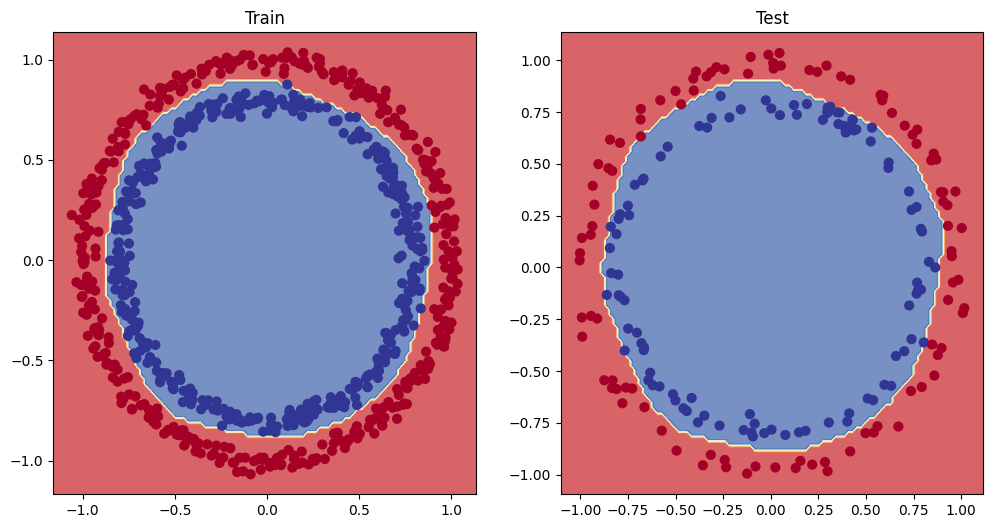

In [42]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## 7. Putting it all together with a multi-class classification problem

### 7.1. Creating a multi-class dataset

In [43]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

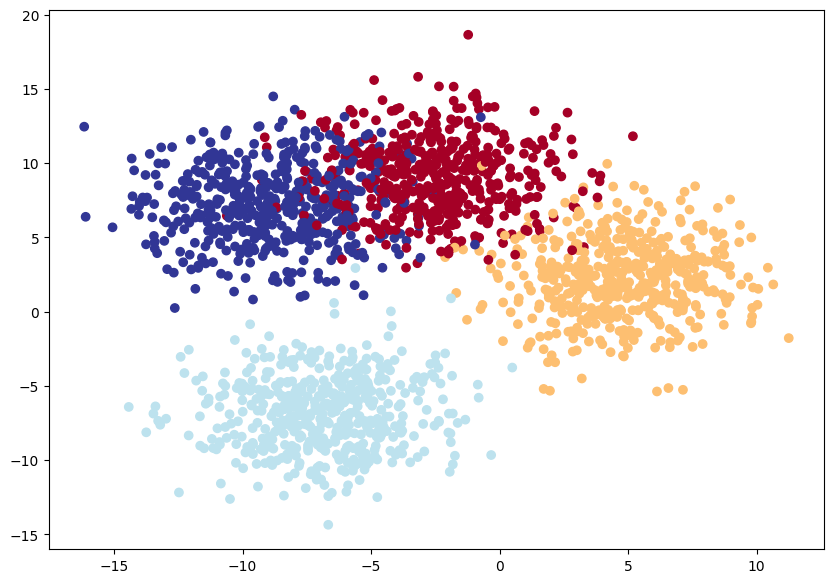

In [68]:
# Hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=2000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=2.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 7.2. Building a multi-class classification model

In [69]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [71]:
# Create an instance of BlobModel and send it to the target device
model_3 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [72]:
# Setting up a loss function and optimizer for the multi-class model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [74]:
# Building a training loop
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_3.train()

  y_logits = model_3(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  # Print
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0868, Acc: 52.62% | Test loss: 1.0419, Test Acc: 52.50%
Epoch: 10 | Loss: 0.7034, Acc: 88.62% | Test loss: 0.7223, Test Acc: 88.00%
Epoch: 20 | Loss: 0.5144, Acc: 92.19% | Test loss: 0.5385, Test Acc: 90.50%
Epoch: 30 | Loss: 0.3645, Acc: 92.62% | Test loss: 0.3758, Test Acc: 91.50%
Epoch: 40 | Loss: 0.2463, Acc: 93.06% | Test loss: 0.2536, Test Acc: 91.75%
Epoch: 50 | Loss: 0.2103, Acc: 93.06% | Test loss: 0.2190, Test Acc: 91.75%
Epoch: 60 | Loss: 0.1978, Acc: 93.19% | Test loss: 0.2065, Test Acc: 91.75%
Epoch: 70 | Loss: 0.1916, Acc: 93.19% | Test loss: 0.1999, Test Acc: 92.00%
Epoch: 80 | Loss: 0.1878, Acc: 93.25% | Test loss: 0.1956, Test Acc: 92.00%
Epoch: 90 | Loss: 0.1852, Acc: 93.38% | Test loss: 0.1924, Test Acc: 92.00%


### 7.3. Making and evaluating predictions with multi-class model

In [75]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 2.4657, -4.5165, -9.8219, -2.3595],
        [-3.6984, -3.9493,  3.2625, -3.0495],
        [-1.3570, -6.7702, -6.2286,  2.6084],
        [-4.3573, -4.8447,  2.9295, -2.3196],
        [-1.5154, -5.0766, -3.8094,  2.2751],
        [-0.9423, -5.7392, -5.3742,  1.9806],
        [-0.4110,  0.6354,  0.6371, -0.5923],
        [-0.6119,  1.8739, -0.9150, -1.7448],
        [-1.1936, -6.2370, -5.7322,  2.3372],
        [ 0.7026, -4.8416, -5.9996,  0.0902]])

In [77]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[9.9112e-01, 9.2006e-04, 4.5676e-06, 7.9541e-03],
        [9.4493e-04, 7.3521e-04, 9.9651e-01, 1.8081e-03],
        [1.8602e-02, 8.2923e-05, 1.4252e-04, 9.8117e-01],
        [6.8020e-04, 4.1778e-04, 9.9368e-01, 5.2190e-03],
        [2.2021e-02, 6.2552e-04, 2.2212e-03, 9.7513e-01],
        [5.0980e-02, 4.2086e-04, 6.0627e-04, 9.4799e-01],
        [1.3274e-01, 3.7795e-01, 3.7858e-01, 1.1073e-01],
        [7.1063e-02, 8.5356e-01, 5.2483e-02, 2.2889e-02],
        [2.8434e-02, 1.8346e-04, 3.0391e-04, 9.7108e-01],
        [6.4632e-01, 2.5272e-03, 7.9382e-04, 3.5036e-01]])

In [78]:
# Gor from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([0, 2, 3, 2, 3, 3, 2, 1, 3, 0])

In [79]:
y_blob_test[:10]

tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0])

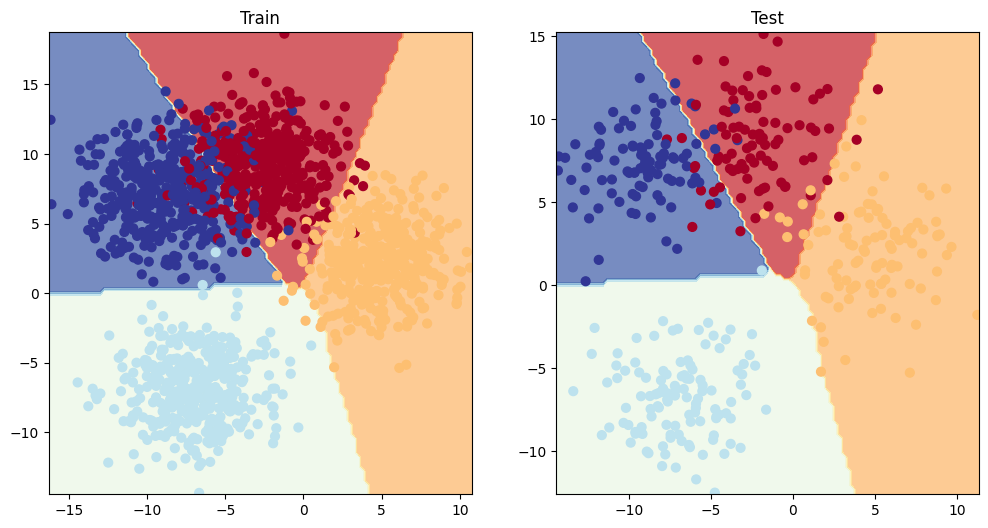

In [80]:
# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test);

## 8. Classification metrics
* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [82]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.4 MB/s eta 0:00:00


In [85]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9200)